In [1]:
import pm4py
import pandas as pd
from matplotlib.dates import SEC_PER_DAY
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as fitness_evaluator
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(pm4py.__version__)

2.7.19


In [3]:
file_path = 'BPI Challenge 2017.xes.gz' 
log = pm4py.read_xes(file_path)

/home/sarra/anaconda3/envs/i2dl/lib/python3.11/site-packages/pm4py/utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [4]:
df = pm4py.convert_to_dataframe(log)

### Basic Analysis

In [5]:
print(df.head(1))
print(df.info())

    Action org:resource          concept:name  EventOrigin  \
0  Created       User_1  A_Create Application  Application   

                 EventID lifecycle:transition  \
0  Application_652823628             complete   

                    time:timestamp           case:LoanGoal  \
0 2016-01-01 09:51:15.304000+00:00  Existing loan takeover   

  case:ApplicationType      case:concept:name  case:RequestedAmount  \
0           New credit  Application_652823628               20000.0   

   FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected  \
0                    NaN            NaN      NaN          NaN      NaN   

   CreditScore  OfferedAmount OfferID  
0          NaN            NaN     NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202267 entries, 0 to 1202266
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   Action                 120226

In [6]:
#basic statistics
num_cases = df['case:concept:name'].nunique()
num_events = len(df)
variants = pm4py.get_variants(log)
num_variants = len(variants)
case_labels = [c for c in df.columns if c.startswith("case:")]
num_case_labels = len(case_labels)
event_labels = [c for c in df.columns if not c.startswith("case:")]
num_event_labels = len(event_labels)
case_lengths = df.groupby("case:concept:name").size()
case_length_mean = case_lengths.mean()
case_length_std = case_lengths.std()
case_group = df.groupby("case:concept:name")["time:timestamp"]
case_start = case_group.min()
case_end = case_group.max()
case_duration = case_end - case_start
case_duration_seconds = case_duration.dt.total_seconds()
duration_mean_sec = case_duration_seconds.mean()
duration_std_sec = case_duration_seconds.std()
sec_per_day = 24 * 60 * 60
duration_mean_days = duration_mean_sec / sec_per_day
duration_std_days = duration_std_sec / sec_per_day
duration_mean_min = duration_mean_sec / 60.0
duration_std_min = duration_std_sec / 60.0
categorical_event_labels = [col for col in event_labels if df[col].dtype == "object"]
num_categorical_event_labels = len(categorical_event_labels)
final_events = df.sort_values("time:timestamp").groupby("case:concept:name").tail(1)
outcome_distribution = final_events["concept:name"].value_counts()
df["event_type"] = df["concept:name"].astype(str).str[0]
event_type_distribution = df["event_type"].value_counts()

#printing the results
print(f"Number of Cases: {num_cases}")
print(f"Number of Events: {num_events}")
print(f"Number of Variants: {num_variants}")
print(f"Number of Case-level Labels: {num_case_labels}")
print(f"Number of Event-level Labels: {num_event_labels}")
print(f"Average Case Length: {case_length_mean:.2f} ± {case_length_std:.2f} events")
print(f"Average Case Duration: {duration_mean_days:.2f} ± {duration_std_days:.2f} days "
      f"({duration_mean_min:.2f} ± {duration_std_min:.2f} minutes)")
print(f"Number of Categorical Event-level Labels: {num_categorical_event_labels}")
print("Outcome Distribution:")
print(outcome_distribution)
print("Event Type Distribution:")
print(event_type_distribution)
print("Min timestamp:", df["time:timestamp"].min())
print("Max timestamp:", df["time:timestamp"].max())

Number of Cases: 31509
Number of Events: 1202267
Number of Variants: 15930
Number of Case-level Labels: 4
Number of Event-level Labels: 15
Average Case Length: 38.16 ± 16.72 events
Average Case Duration: 21.90 ± 13.17 days (31535.43 ± 18963.69 minutes)
Number of Categorical Event-level Labels: 9
Outcome Distribution:
concept:name
W_Validate application        12662
W_Call after offers            9457
W_Call incomplete files        4676
O_Cancelled                    4436
W_Complete application          144
W_Assess potential fraud        102
O_Sent (mail and online)         15
O_Sent (online only)              8
W_Shortened completion            5
W_Personal Loan collection        2
A_Denied                          1
O_Returned                        1
Name: count, dtype: int64
Event Type Distribution:
event_type
W    768823
A    239595
O    193849
Name: count, dtype: int64
Min timestamp: 2016-01-01 09:51:15.304000+00:00
Max timestamp: 2017-02-01 14:11:03.499000+00:00


#### Calculating variant statistics

Found 80% cutoff at k=9629
Top 20 variants cover 19.6% of the log.


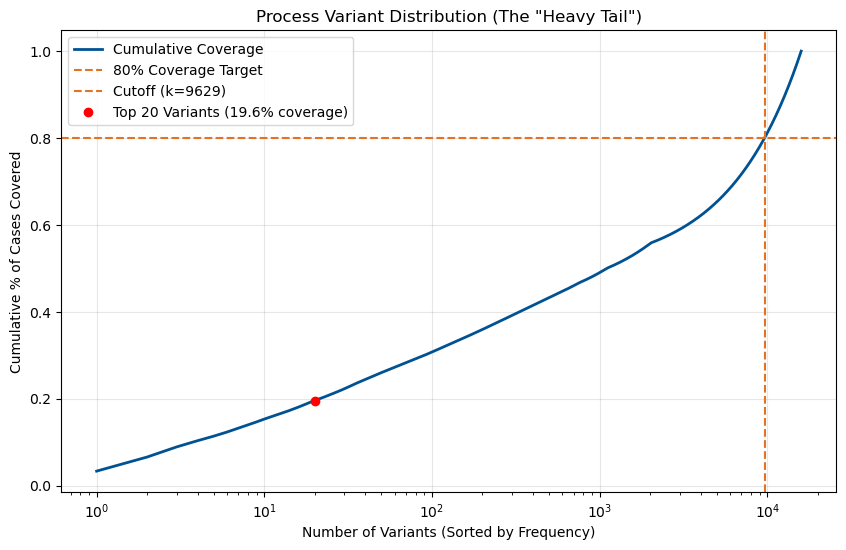

In [7]:
variants = pm4py.get_variants_as_tuples(log)
sorted_variants = sorted(
    variants.items(),
    key=lambda x: x[1] if isinstance(x[1], int) else len(x[1]),
    reverse=True
)
counts = [x[1] if isinstance(x[1], int) else len(x[1]) for x in sorted_variants]

total_cases = sum(counts)
cumulative_counts = np.cumsum(counts)
cumulative_percent = cumulative_counts / total_cases
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(counts) + 1), cumulative_percent, label='Cumulative Coverage', color='#005293', linewidth=2)

#80% of cases
try:
    k_80 = next(i for i, p in enumerate(cumulative_percent) if p >= 0.80) + 1
    plt.axhline(y=0.80, color='#e37222', linestyle='--', label='80% Coverage Target')
    plt.axvline(x=k_80, color='#e37222', linestyle='--', label=f'Cutoff (k={k_80})')
    print(f"Found 80% cutoff at k={k_80}")
except StopIteration:
    print("Warning: Could not find 80% cutoff (coverage might be low).")

#top 20 variants]
if len(cumulative_percent) >= 20:
    k_20 = 20
    coverage_20 = cumulative_percent[19]
    plt.plot(k_20, coverage_20, 'ro', label=f'Top 20 Variants ({coverage_20:.1%} coverage)')
    print(f"Top 20 variants cover {coverage_20:.1%} of the log.")
plt.title('Process Variant Distribution (The "Heavy Tail")')
plt.xlabel('Number of Variants (Sorted by Frequency)')
plt.ylabel('Cumulative % of Cases Covered')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

### Process Model Creation and Validation

#### Applying discovery algorithms

In [8]:
#we remove the cases that have a duration over 1740 hours
df = df.sort_values(by=["case:concept:name", "time:timestamp"]).reset_index(drop=True)
case_group = df.groupby("case:concept:name")["time:timestamp"]
case_duration_seconds = (case_group.max() - case_group.min()).dt.total_seconds()
valid_case_ids = case_duration_seconds[case_duration_seconds <= (1740 * 3600)].index
df_duration_filtered = df[df["case:concept:name"].isin(valid_case_ids)].copy()
log_duration_filtered = pm4py.convert_to_event_log(df_duration_filtered)
print(f"Cases remaining after duration filter: {len(log_duration_filtered)}")

#applying discovery algorithms on full log

#calculating how many variants 'k' are needed to cover 80% of cases
variants = pm4py.get_variants_as_tuples(log_duration_filtered)
sorted_variants = sorted(variants.items(), key=lambda x: len(x[1]), reverse=True)
total_cases = len(log_duration_filtered)
target_cases = total_cases * 0.80
current_cases = 0
k_80 = 0
for variant, cases in sorted_variants:
    current_cases += len(cases)
    k_80 += 1
    if current_cases >= target_cases:
        break
print(f"To cover 80% of cases, we kept the top {k_80} variants.")
log_80 = pm4py.filter_variants_top_k(log_duration_filtered, k=k_80)

#applying discovery algorithms (inductive and heuristics) on 80% of the cases 
#Inductive miner
print("---Inductive Miner---")
tree_80 = inductive_miner.apply(log_80)
net_80, im_80, fm_80 = pt_converter.apply(tree_80)
fitness_80 = fitness_evaluator.apply(log_duration_filtered, net_80, im_80, fm_80, variant=fitness_evaluator.Variants.TOKEN_BASED)
print(f"fitness on full log: {fitness_80['log_fitness']:.4f}")
bpmn_model = pt_converter.apply(tree_80, variant=pt_converter.Variants.TO_BPMN)
pm4py.write_bpmn(bpmn_model, "inductive_model.bpmn")
print("Saved 'inductive_model.bpmn' (Analytical Model)")

#heuristics miner
print("---Heuristics Miner---")
net_heu, im_heu, fm_heu = pm4py.discover_petri_net_heuristics(log_80)
gviz_heu = pn_visualizer.apply(net_heu, im_heu, fm_heu)
pn_visualizer.save(gviz_heu, "heuristics_petri_net.png")
fitness_heu = fitness_evaluator.apply(log_duration_filtered, net_heu, im_heu, fm_heu, variant=fitness_evaluator.Variants.TOKEN_BASED)
print(f"fitness on full log: {fitness_heu['log_fitness']:.4f}")

#calculating precision and generalization only on top 20 variants for the inductive miner
log_visual = pm4py.filter_variants_top_k(log_duration_filtered, k=20)

print("---Inductive Miner (limited)---")
tree_visual = inductive_miner.apply(log_visual)
net_visual, im_visual, fm_visual = pt_converter.apply(tree_visual)
gviz_visual = pn_visualizer.apply(net_visual, im_visual, fm_visual)
pn_visualizer.save(gviz_visual, "inductive_model_visual_top20.png")
print("Saved 'inductive_model_visual_top20.png' (Visual Model)")
sample_size = 500
df_visual = pm4py.convert_to_dataframe(log_visual)
unique_cases_visual = df_visual["case:concept:name"].drop_duplicates()
sample_ids = unique_cases_visual.sample(n=min(sample_size, len(unique_cases_visual)), random_state=42)
df_sample = df_visual[df_visual["case:concept:name"].isin(sample_ids)]
log_sample = pm4py.convert_to_event_log(df_sample)
prec_val = precision_evaluator.apply(log_sample, net_visual, im_visual, fm_visual)
gen_val = generalization_evaluator.apply(log_sample, net_visual, im_visual, fm_visual)
print(f"Inductive Visual Model - Precision: {prec_val:.4f}")
print(f"Inductive Visual Model - Generalization: {gen_val:.4f}")

print("---Heuristics Miner (limited)---")
net_heu_visual, im_heu_visual, fm_heu_visual = pm4py.discover_petri_net_heuristics(log_visual)
prec_heu_visual = precision_evaluator.apply(log_sample, net_heu_visual, im_heu_visual, fm_heu_visual)
gen_heu_visual = generalization_evaluator.apply(log_sample, net_heu_visual, im_heu_visual, fm_heu_visual)
print(f"Heuristics Visual Model - Precision: {prec_heu_visual:.4f}")
print(f"Heuristics Visual Model - Generalization: {gen_heu_visual:.4f}")

#additional simplicity metrics
def calculate_metric_6(net):
    """Metric 6: Simple Structural Appropriateness"""
    num_t = len(net.transitions)
    num_p = len(net.places)
    visible_labels = {t.label for t in net.transitions if t.label is not None}
    if num_t + num_p == 0: return 0
    return (len(visible_labels) + 2) / (num_t + num_p)

def calculate_metric_7(net):
    """Metric 7: Advanced Structural Appropriateness"""
    num_t = len(net.transitions)
    if num_t == 0: return 0
    visible_labels = [t.label for t in net.transitions if t.label is not None]
    counts = Counter(visible_labels)
    t_da = sum(c - 1 for c in counts.values() if c > 1)
    t_ir = sum(1 for t in net.transitions if t.label is None)
    return (num_t - (t_da + t_ir)) / num_t

print(f"Inductive (80%) - SSA: {calculate_metric_6(net_80):.4f}")
print(f"Inductive (80%) - ASA: {calculate_metric_7(net_80):.4f}")
print(f"Heuristics (80%) - SSA: {calculate_metric_6(net_heu):.4f}")
print(f"Heuristics (80%) - ASA: {calculate_metric_7(net_heu):.4f}")

Cases remaining after duration filter: 31388
To cover 80% of cases, we kept the top 9534 variants.
---Inductive Miner---


replaying log with TBR, completed traces ::   0%|          | 0/15811 [00:00<?, ?it/s]

fitness on full log: 1.0000
Saved 'inductive_model.bpmn' (Analytical Model)
---Heuristics Miner---


replaying log with TBR, completed traces ::   0%|          | 0/15811 [00:00<?, ?it/s]

fitness on full log: 0.9533
---Creating Model with top 20 variants---
---Inductive Miner (Visual)---
Saved 'inductive_model_visual_top20.png' (Visual Model)


computing precision with alignments, completed variants ::   0%|          | 0/255 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/20 [00:00<?, ?it/s]

Inductive Visual Model - Precision: 0.3291
Inductive Visual Model - Generalization: 0.9226
---Heuristics Miner (Visual)---


computing precision with alignments, completed variants ::   0%|          | 0/255 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/20 [00:00<?, ?it/s]

Heuristics Visual Model - Precision: 0.5491
Heuristics Visual Model - Generalization: 0.9226
Inductive (80%) - SSA: 0.1971
Inductive (80%) - ASA: 0.3012
Heuristics (80%) - SSA: 0.2571
Heuristics (80%) - ASA: 0.3731


In [9]:
try:
    bpmn_refined = pm4py.read_bpmn("refined.bpmn")
    net_ref, im_ref, fm_ref = pm4py.convert_to_petri_net(bpmn_refined)
    fitness_ref = fitness_evaluator.apply(log_duration_filtered, net_ref, im_ref, fm_ref, variant=fitness_evaluator.Variants.TOKEN_BASED)
    print(f"Refined Model Fitness: {fitness_ref['log_fitness']:.4f}")
    precision_ref = precision_evaluator.apply(log_sample, net_ref, im_ref, fm_ref)
    print(f"Refined Model Precision: {precision_ref:.4f}")
    simp_ref = calculate_metric_6(net_ref)
    print(f"Refined Model SSA: {simp_ref:.4f}")
    gen_ref=generalization_evaluator.apply(log_sample, net_ref, im_ref, fm_ref)
    print(f"Refined Model Generalization: {gen_ref:.4f}")
    struct_ref=calculate_metric_7(net_ref)
    print(f"Refined Model ASA: {struct_ref:.4f}")

except Exception as e:
    print(f"file .bpmn not found")

replaying log with TBR, completed traces ::   0%|          | 0/15811 [00:00<?, ?it/s]

Refined Model Fitness: 0.5256


computing precision with alignments, completed variants ::   0%|          | 0/255 [00:00<?, ?it/s]

Refined Model Precision: 0.7914
Refined Model Simplicity (Metric 6): 0.5263


replaying log with TBR, completed traces ::   0%|          | 0/20 [00:00<?, ?it/s]

Refined Model Generalization: 0.6209
Refined Model Structuredness: 0.7826


#### separating "Limit Raise" and "New Credit" types of application

In [10]:
#splitting the log 
df_limit = df[df['case:ApplicationType'] == 'Limit raise']
df_new = df[df['case:ApplicationType'] == 'New credit']
log_limit = pm4py.convert_to_event_log(df_limit)
log_new = pm4py.convert_to_event_log(df_new)
#we filter both to top 20 variants
log_limit_20 = pm4py.filter_variants_top_k(log_limit, k=20)
log_new_20 = pm4py.filter_variants_top_k(log_new, k=20)

def get_precision(sub_log):
    if len(sub_log) == 0: return 0.0
    # Discover on Top 20
    tree = inductive_miner.apply(sub_log)
    net, im, fm = pt_converter.apply(tree)
    # Measure on Top 20
    return precision_evaluator.apply(sub_log, net, im, fm)

prec_limit = get_precision(log_limit_20)
prec_new = get_precision(log_new_20)
print(f"Limit Raise Model (Top 20 variants): {prec_limit:.4f}")
print(f"New Credit Model (Top 20 variants): {prec_new:.4f}")

computing precision with alignments, completed variants ::   0%|          | 0/205 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/247 [00:00<?, ?it/s]

Limit Raise Model (Top 20 variants): 0.4568
New Credit Model (Top 20 variants): 0.3384


#### filtering the non-complete events and the loops

In [11]:
print("Distribution of lifecycle transitions:")
print(df['lifecycle:transition'].value_counts())
# We keep only 'complete' events. This removes the start/suspend/resume loops.
print("\nFiltering out 'ping-pong' events (keeping only 'complete')...")
df_refined = df[df['lifecycle:transition'].str.lower() == 'complete'].copy()
#inductive model on df_refined
log_refined = pm4py.convert_to_event_log(df_refined)
#using variants that cover 80% of the data 
variants = pm4py.get_variants_as_tuples(log_refined)
sorted_variants = sorted(variants.items(), key=lambda x: len(x[1]), reverse=True)
total_cases = len(log_refined)
target_cases = total_cases * 0.80
current_cases = 0
k = 0
for variant, cases in sorted_variants:
    current_cases += len(cases)
    k += 1
    if current_cases >= target_cases:
        break

print(f"Using top {k} variants (covering 80% of refined cases).")
log_final = pm4py.filter_variants_top_k(log_refined, k)
tree = pm4py.discover_process_tree_inductive(log_final)
net, im, fm = pm4py.convert_to_petri_net(tree)
sample_log = pm4py.sample_cases(log_refined, 500)
precision = pm4py.precision_alignments(sample_log, net, im, fm)
print(f"Refined Model Precision: {precision:.4f}")
log_refined_visual = pm4py.filter_variants_top_k(log_refined, k=20)
tree_ref = pm4py.discover_process_tree_inductive(log_refined_visual)
net_ref, im_ref, fm_ref = pm4py.convert_to_petri_net(tree_ref)
if len(log_refined_visual) > 500:
    sample_refined = pm4py.sample_cases(log_refined_visual, 500)
else:
    sample_refined = log_refined_visual

precision_ref = pm4py.precision_alignments(sample_refined, net_ref, im_ref, fm_ref)
print(f"Refined 'No-Loop' Model (Top 20) Precision: {precision_ref:.4f}")

Distribution of lifecycle transitions:
lifecycle:transition
complete     475306
suspend      215402
schedule     149104
start        128227
resume       127160
ate_abort     85224
withdraw      21844
Name: count, dtype: int64

Filtering out 'ping-pong' events (keeping only 'complete')...
Using top 610 variants (covering 80% of refined cases).


computing precision with alignments, completed variants ::   0%|          | 0/1248 [00:00<?, ?it/s]

Refined Model Precision: 0.2199


computing precision with alignments, completed variants ::   0%|          | 0/72 [00:00<?, ?it/s]

Refined 'No-Loop' Model (Top 20) Precision: 0.6818
